<a href="https://colab.research.google.com/github/jaspersprakel/queueing_book/blob/master/notebooks/emas_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Assignment Data Science

**Introduction**

Over the past decade, platforms like Airbnb have transformed the way people travel, offering flexible and personalized alternatives to traditional hotel accommodations. With thousands of listings in major cities around the world, platforms like Airbnb not only facilitate short-term rentals but also generate a large amount of user-generated data, including guest reviews. These reviews serve as a valuable source of insight, reflecting the quality of listings, guest satisfaction, and overall experiences.

In this project, the focus is on analyzing Airbnb listings in New York City with the goal of understanding the factors that influence a listing’s overall review score. The review score is a key indicator of listing quality and guest experience, and understanding what drives higher (or lower) scores can benefit both hosts and potential guests. For hosts, it offers guidance on how to improve their service and increase competitiveness; for guests, it helps in making informed booking decisions.

Using the Inside Airbnb dataset, a range of machine learning and statistical techniques are applied to explore which features such as location, room type, host behavior, availability, and price are most predictive of review scores. The analysis includes a combination of exploratory data analysis, data cleaning, feature engineering, and predictive modeling using linear regressions and XGBoost.

This analysis also aims to demonstrate how data science can be applied to real-world consumer platforms to extract meaningful insights from publicly available data. By identifying patterns in user behavior and listing characteristics, we provide a deeper understanding of what drives guest satisfaction.

The remainder of this report covers the data preparation process, modeling approach, and evaluation of results, followed by a discussion of key takeaways, limitations, and suggestions for future work.

In [123]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-data-science-emas
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!jupyter nbextension enable --py widgetsnbextension

**Import packages**

In [124]:
import os
print(os.getcwd())
os.chdir("teaching-data-science-emas/notebooks")

/content/teaching-data-science-emas/notebooks


Importing all the required packages:

In [125]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,  accuracy_score, roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb
#from xgboost import XGBRegressor
import io
from google.colab import files
import math

In [126]:
%matplotlib inline

## 1. Load dataset & Elementary Data Analysis

### 1.1 Load and inspect data

Load dataset into a pandas dataframe:

In [127]:
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))

Saving listings 2.csv to listings 2.csv


<ipython-input-127-be9cd142c138>:2: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(io.BytesIO(uploaded['listings 2.csv']))


The dataset is first split into a "train set" and a "validation set".

In [142]:
seed = 123
train_df, aux_df = train_test_split(dataset, train_size=.5, random_state=seed)
validation_df, test_df = train_test_split(aux_df, train_size=.5, random_state=seed)

print(f"data_train shape: {train_df.shape}")
print(f"data_validation shape: {validation_df.shape}")
print(f"data_test shape: {test_df.shape}")
#del dataset

data_train shape: (18705, 74)
data_validation shape: (9352, 74)
data_test shape: (9353, 74)


Let us inspect the first 3 and the last 3 rows of the dataset:

In [129]:
pd.options.display.max_columns = 100
display(train_df.head(3))
display(train_df.tail(3))

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
8133,12686241,https://www.airbnb.com/rooms/12686241,20220603182654,2022-06-04,Large Front Facing Bedroom & Private Backyard,Large bedroom on Garden floor with backyard ac...,NaN,https://a0.muscache.com/pictures/58451700-6447...,30848788,https://www.airbnb.com/users/show/30848788,Jamie,2015-04-08,"De Kalb, Mississippi, United States",NaN,within a few hours,90%,75%,f,https://a0.muscache.com/im/pictures/user/706a1...,https://a0.muscache.com/im/pictures/user/706a1...,Bedford-Stuyvesant,2.0,2.0,"['email', 'phone']",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.69462,-73.94693,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,1.0,"[""Essentials"", ""Cooking basics"", ""Wifi"", ""Carb...",$125.00,4,150,4.0,4.0,150.0,150.0,4.0,150.0,NaN,t,29,59,89,89,2022-06-04,51,1,0,2016-05-11,2022-04-27,4.69,4.75,4.69,4.94,4.98,4.57,4.59,NaN,f,2,0,2,0,0.69
24373,45261941,https://www.airbnb.com/rooms/45261941,20220603182654,2022-06-03,A+ Location Classic Studio Suite(2 Double Beds),Our apartment is located in the center of Manh...,This is a very central location where you can ...,https://a0.muscache.com/pictures/d415db7b-95f0...,348619646,https://www.airbnb.com/users/show/348619646,Nomad,2020-06-03,"New York, New York, United States",We are delighted to accommodate you during you...,within an hour,100%,99%,f,https://a0.muscache.com/im/pictures/user/00285...,https://a0.muscache.com/im/pictures/user/00285...,NaN,55.0,55.0,"['email', 'phone']",t,t,"New York, United States",Midtown,Manhattan,40.74797,-73.98847,Entire rental unit,Entire home/apt,4,NaN,1 bath,NaN,2.0,"[""Conditioner"", ""Essentials"", ""Washer"", ""Cooki...",$276.00,1,1125,1.0,10.0,1125.0,1125.0,3.3,1125.0,NaN,t,10,34,64,276,2022-06-03,41,33,1,2020-09-06,2022-05-20,4.49,4.37,4.54,4.61,4.88,4.85,4.46,NaN,t,54,39,15,0,1.93
35726,602777088581961008,https://www.airbnb.com/rooms/602777088581961008,20220603182654,2022-06-03,Sweet SoHo 1 Bedroom,(AC works!) The best location in NYC! Steps fr...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,236369220,https://www.airbnb.com/users/show/236369220,Andrea,2019-01-13,"New York, New York, United States",NaN,within a day,75%,46%,f,https://a0.muscache.com/im/pictures/user/bb833...,https://a0.muscache.com/im/pictures/user/bb833...,NaN,0.0,0.0,"['email', 'phone']",t,t,NaN,Nolita,Manhattan,40.72136,-73.99617,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Cooking basics...",$283.00,6,40,6.0,28.0,40.0,40.0,8.7,40.0,NaN,t,8,8,8,8,2022-06-03,6,6,2,2022-04-16,2022-05-24,4.83,4.83,4.83,4.83,4.83,4.83,4.83,NaN,f,1,1,0,0,3.67


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
17730,32549155,https://www.airbnb.com/rooms/32549155,20220603182654,2022-06-04,BK Home Away From Home,Charming 2 bedroom apartment on top floor of w...,"Home of Junior's Cheesecake, Coney Island, Bar...",https://a0.muscache.com/pictures/85873401-13c6...,244596528,https://www.airbnb.com/users/show/244596528,Mary Ann,2019-02-21,"Brooklyn, New York, United States","Born and raised in Brooklyn, New York. Gradua...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/69486...,https://a0.muscache.com/im/pictures/user/69486...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Bedford-Stuyvesant,Brooklyn,40.69002,-73.934200,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Essentials"", ""Extra pillows and blankets"", ""...",$109.00,2,27,2.0,2.0,27.0,27.0,2.0,27.0,NaN,t,1,1,1,24,2022-06-04,116,50,4,2019-05-07,2022-05-27,4.78,4.86,4.82,4.98,4.91,4.69,4.84,NaN,f,1,1,0,0,3.09
28030,50152840,https://www.airbnb.com/rooms/50152840,20220603182654,2022-06-04,A lovely smart home in Williamsburg-Greenpoint,Stay in a sun-filled apartment with smart-home...,North Brooklyn (Greenpoint/Williamsburg) – the...,https://a0.muscache.com/pictures/22f41221-7b98...,6796668,https://www.airbnb.com/users/show/6796668,Milan,2013-06-08,"New York, New York, United States",I’m a New York based design and branding profe...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/9934d...,https://a0.muscache.com/im/pictures/user/9934d...,Williamsburg,1.0,1.0,"['email', 'phone']",t,t,"Brooklyn, New York, United States",Williamsburg,Brooklyn,40.71941,-73.943146,Entire condo,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Baby monitor"", ""Table corner guards"", ""Wine ...",$200.00,31,365,31.0,31.0,365.0,365.0,31.0,365.0,NaN,t,0,0,0,69,2022-06-04,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
15725,28220182,https://www.airbnb.com/rooms/28220182,20220603182654,2022-06-04,New Charming 1 Bedroom Oasis Apartment,A Newly renovated fully furnished one bedroom ...,The neighborhood is historic and surrounded by...,https://a0.muscache.com/pictures/38fa5d92-4957...,35387196,https://www.airbnb.com/users/show/35387196,Kizzie,2015-06-09,"Brooklyn, New York, United States",NaN,within a few hours,80%,75%,f,https://a0.muscache.com/im/pictures/user/93ed6...,https://a0.muscache.com/im/pictures/user/93ed6...,Crown Heights,2.0,2.0,"['email', 'phone', 'work_email']",t,t,"Brooklyn, New York, United States",Prospect-Lefferts Gardens,Brooklyn,40.66130,-73.953650,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Carbon monoxide alarm"", ""Heating"", ""Essentia...",$110.00,7,365,7.0,7.0,365.0,365.0,7.0,365.0,NaN

Some meta-data:

In [130]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18705 entries, 8133 to 15725
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18705 non-null  int64  
 1   listing_url                                   18705 non-null  object 
 2   scrape_id                                     18705 non-null  int64  
 3   last_scraped                                  18705 non-null  object 
 4   name                                          18699 non-null  object 
 5   description                                   18266 non-null  object 
 6   neighborhood_overview                         11155 non-null  object 
 7   picture_url                                   18705 non-null  object 
 8   host_id                                       18705 non-null  int64  
 9   host_url                                      18705 non-null  o

See link below for a description of the columns.

https://www.kaggle.com/datasets/dominoweir/inside-airbnb-nyc?select=listings+2.csv

## 1.1 Summary statistics

In [131]:
train_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.870500e+04,1.870500e+04,1.870500e+04,18678.00000,18678.00000,18705.000000,18705.000000,18705.000000,0.0,16891.000000,18258.000000,18705.000000,1.870500e+04,18698.000000,18698.000000,1.869800e+04,1.869800e+04,18698.000000,1.869800e+04,0.0,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000,14524.000000,14531.000000,14521.000000,14527.000000,14519.000000,14519.000000,18705.000000,18705.000000,18705.000000,18705.000000,14777.000000
mean,6.036603e+16,2.022060e+13,1.229774e+08,61.88275,61.88275,40.729352,-73.946139,2.886234,NaN,1.349239,1.628053,19.825982,1.689919e+03,20.538293,27.511285,1.609759e+06,3.447383e+06,26.956974,2.460680e+06,NaN,4.669607,12.763111,23.434162,118.674739,26.004812,7.150922,0.748196,4.605712,4.742139,4.619499,4.813230,4.804369,4.745772,4.643509,15.002887,9.251911,5.620957,0.053836,1.147048
std,1.797305e+17,1.902395e+00,1.372348e+08,393.59663,393.59663,0.058142,0.056978,1.934833,NaN,0.733566,1.145854,33.249508,1.462313e+05,41.963464,79.123872,5.874166e+07,8.595202e+07,77.234696,6.704375e+07,NaN,8.177008,18.598467,29.536626,132.660181,53.921664,18.351724,1.775041,0.773487,0.482023,0.560597,0.418888,0.448629,0.405130,0.504071,50.470021,45.107521,23.839727,0.519034,1.800730
min,2.595000e+03,2.022060e+13,2.438000e+03,0.00000,0.00000,40.508630,-74.266750,0.000000,NaN,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.422859e+07,2.022060e+13,1.263910e+07,1.00000,1.00000,40.688420,-73.983600,2.000000,NaN,1.000000,1.000000,2.000000,6.000000e+01,2.000000,3.000000,3.600000e+02,3.650000e+02,2.000000,3.650000e+02,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.570000,4.700000,4.500000,4.800000,4.800000,4.670000,4.550000,1.000000,0.000000,0.000000,0.000000,0.120000
50%,3.439381e+07,2.022060e+13,5.435116e+07,1.00000,1.00000,40.724900,-73.953910,2.000000,NaN,1.000000,1.000000,30.000000,3.650000e+02,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,0.000000,0.000000,6.000000,58.000000,5.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.950000,4.960000,4.860000,4.770000,1.000000,1.000000,0.000000,0.000000,0.480000
75%,4.989833e+07,2.022060e+13,2.069725e+08,3.00000,3.00000,40.763250,-73.926760,4.000000,NaN,1.000000,2.000000,30.000000,1.125000e+03,30.000000,30.000000,1.125000e+03,1.125000e+03,30.000000,1.125000e+03,NaN,6.000000,23.000000,44.000000,251.000000,25.000000,6.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.960000,3.000000,1.000000,1.000000,0.000000,1.600000
max,6.412414e+17,2.022060e+13,4.623937e+08,3404.00000,3404.00000,40.928340,-73.704260,16.000000,NaN,15.000000,42.000000,1250.000000,2.000000e+07,1250.000000,1250.000000,2.147484e+09,2.147484e+09,1250.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1419.000000,909.000000,72.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,391.000000,391.000000,190.000000,11.000000,68.580000


## 1.2 Cleansing

Check for missing values:

In [136]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

,0
host_since,27
host_location,77
host_response_time,6687
host_response_rate,6687
host_acceptance_rate,5941
host_is_superhost,27
host_listings_count,27
host_verifications,27
host_has_profile_pic,27
host_identity_verified,27


List all the variables in the dataset:

In [137]:
print(train_df.columns.tolist())

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

Selecting the columns relevant for the analysis:

In [143]:
columns_to_keep = ['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
train_df = train_df[columns_to_keep]
print(train_df.columns.tolist())
len(train_df.columns)

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

48

## 1.3 Univariate plots

Distribution of th target variable review rating:

Recall, that we are interested in the review_scores_rating for a rental from AirBnB.
The distribution of the target in the train set:


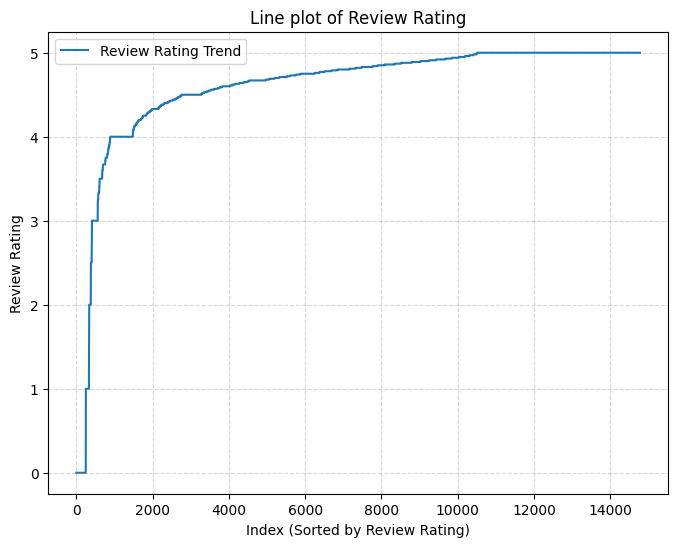

,review_scores_rating
count,14777.000000
mean,4.605712
std,0.773487
min,0.000000
25%,4.570000
50%,4.820000
75%,5.000000
max,5.000000


In [139]:
print("Recall, that we are interested in the review_scores_rating for a rental from AirBnB.")
print("The distribution of the target in the train set:")
# Sort prices for a line plot
sorted_review_ratings = np.sort(train_df["review_scores_rating"].values)

# Create a line plot
plt.figure(figsize=(8, 6), facecolor="white")
plt.plot(sorted_review_ratings, label="Review Rating Trend")
plt.xlabel("Index (Sorted by Review Rating)")
plt.ylabel("Review Rating")
plt.title("Line plot of Review Rating")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

train_df["review_scores_rating"].describe()

Some data preparation:

In [144]:
print(f"The data type of the prices is {type(train_df['review_scores_rating'].loc[0])}\n")
print("This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.")
train_df["price"] = train_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
print(f"The data type of the target is now {type(train_df['price'].loc[0])}\n")
train_df["price"].describe()

#Repeating the same for the validation and test set:
validation_df["price"] = validation_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
test_df["price"] = test_df["price"].str.replace("$", "").str.replace(",", "").astype(float)

The data type of the prices is <class 'numpy.float64'>

This is because the prices include a $ sign. Therefore we should remove these and convert the data to numerical.
The data type of the target is now <class 'numpy.float64'>



In [145]:
print(f"From the description table, we find that there are some rentals with a price of 0, namely {(train_df['price'] == 0).sum()}.")
print(f"Looking closer at these {(train_df['price'] == 0).sum()} observations, we find that they have quite some missing data as well as no availability for the coming 365 days.")
print("As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.")

train_df[train_df["price"] == 0]

From the description table, we find that there are some rentals with a price of 0, namely 12.
Looking closer at these 12 observations, we find that they have quite some missing data as well as no availability for the coming 365 days.
As the price of 0 does not seem reasonable, these observations are excluded from the analysis as they will not provide any helpful insights.


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
22655,42384501,262458398,2019-05-17,"New York, New York, United States",within an hour,100%,100%,f,2.0,"['email', 'phone', 'work_email']",t,t,Manhattan,40.747930,-73.991170,Room in boutique hotel,Hotel room,2,NaN,NaN,NaN,"[""Valet parking \u2014 $65/day"", ""Pets allowed...",0.0,NaN,NaN,t,0,0,0,0,83,15,0,2019-10-05,2022-04-17,4.39,4.54,4.51,4.69,4.45,4.73,4.41,f,1,0,0,0,2.56
22318,41740615,268417148,2019-06-13,"New York, New York, United States",within an hour,100%,100%,f,0.0,"['email', 'phone', 'work_email']",t,t,Manhattan,40.744590,-73.985740,Room in boutique hotel,Hotel room,4,NaN,NaN,NaN,"[""Onsite bar \u2014 The Seville"", ""Valet parki...",0.0,1.0,28.0,t,0,0,0,0,40,11,1,2019-11-01,2022-05-22,4.33,4.45,4.65,4.33,4.30,4.65,4.35,f,1,0,0,0,1.27
23310,43247386,335072254,2020-02-10,US,within an hour,100%,87%,f,5.0,"['email', 'phone']",t,t,Manhattan,40.767560,-73.983120,Room in hotel,Hotel room,0,NaN,NaN,NaN,"[""C.O. Bigelow Apothecary toiletries"", ""Bed sh...",0.0,NaN,NaN,t,0,0,0,0,14,14,1,2021-06-06,2022-05-08,3.71,3.64,3.86,4.21,4.00,4.71,3.71,f,1,0,0,0,1.15
26310,48089897,261016212,2019-05-10,US,within an hour,100%,0%,f,10.0,"['email', 'phone']",t,t,Brooklyn,40.696787,-73.958005,Room in hotel,Hotel room,0,NaN,NaN,NaN,"[""Bathtub"", ""Toiletries"", ""Bed sheets and pill...",0.0,NaN,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22604,42279171,265458818,2019-05-31,"New York, New York, United States",within an hour,100%,98%,f,6.0,"['email', 'phone']",t,t,Manhattan,40.716100,-73.995180,Room in boutique hotel,Hotel room,6,NaN,NaN,NaN,"[""Carbon monoxide alarm"", ""Heating"", ""42\"" TV""...",0.0,1.0,365.0,t,0,0,0,0,309,142,7,2019-08-19,2022-05-19,4.50,4.58,4.66,4.66,4.59,4.66,4.50,f,1,0,0,0,9.08
26510,48325676,390077597,2021-02-25,US,within an hour,100%,90%,f,0.0,"['email', 'phone']",t,t,Manhattan,40.781629,-73.982004,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,"[""Concierge"", ""Dryer"", ""Stove"", ""Refrigerator""...",0.0,NaN,NaN,t,0,0,0,0,2,2,0,2021-09-16,2021-12-11,5.00,5.00,5.00,5.00,5.00,5.00,4.00,f,1,0,0,0,0.23
25093,46251446,374516933,2020-11-05,"New York, New York, United States",within an hour,100%,72%,t,0.0,"['email', 'phone']",t,t,Manhattan,40.719732,-73.993996,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,"[""Housekeeping"", ""Heating"", ""Hair dryer"", ""Saf...",0.0,NaN,NaN,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22494,42065543,307634016,2019-11-06,"New York, New York, United States",within an hour,100%,100%,f,4.0,"['email', 'phone']",t,t,Manhattan,40.744440,-73.989200,Room in boutique hotel,Hotel room,4,NaN,NaN,NaN,"[""Bathtub"", ""Geneva Guild toiletries"", ""Bed sh...",0.0,1.0,1125.0,t,0,0,0,0,316,163,5,2020-11-01,2022-05-25,4.66,4.72,4.69,4.87,4.86,4.89,4.61,f,1,0,0,0,16.34
23197,43078550,334334264,2020-02-07,US,NaN,NaN,NaN,f,0.0,['phone'],t,t,Manhattan,40.740970,-73.983390,Room in boutique hotel,Hotel room,0,NaN,NaN,NaN,"[""Garnier-Thiebaut linens"", ""Pets allowed"", ""F...",0.0,30.0,1125.0,t,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,1,0,0,0,NaN
22584,42228

In [146]:
train_df = train_df[train_df['price'] != 0]

The host_response_rate and the host_acceptance_rate show a special character, making them non numeric. Therefore a similar transformation to the price variable should be performed to make them numeric, to apply them in further analysis.

In [147]:
train_df["host_response_rate"] = train_df["host_response_rate"].str.replace("%", "").astype(float)
train_df["host_acceptance_rate"] = train_df["host_acceptance_rate"].str.replace("%", "").astype(float)

#Repeating the same for the validation and test set:
validation_df["host_response_rate"] = validation_df["host_response_rate"].str.replace("%", "").astype(float)
validation_df["host_acceptance_rate"] = validation_df["host_acceptance_rate"].str.replace("%", "").astype(float)
test_df["host_response_rate"] = test_df["host_response_rate"].str.replace("%", "").astype(float)
test_df["host_acceptance_rate"] = test_df["host_acceptance_rate"].str.replace("%", "").astype(float)

The location of the host might be an interesting column, however given the amount of unique values it seems better to create a dummy variable to see if the host location is in New York or not.

In [148]:
train_df['host_location_NY'] = train_df['host_location'].str.lower().str.contains("new york", na=False).astype(int)
train_df['host_location'].nunique()

1226

In [149]:
#Repeating the same for the validation and test set:
validation_df['host_location_NY'] = validation_df['host_location'].str.lower().str.contains("new york", na=False).astype(int)
test_df['host_location_NY'] = test_df['host_location'].str.lower().str.contains("new york", na=False).astype(int)

Similarly the bath column can be split up into 0, 1 or more baths and the property type into entire rental unit and private room in rental unit. As these occur most frequently (see categorical plots below).

In [150]:
def add_custom_dummies(df):
    # Property type dummies
    df['entire_rental_unit'] = (df['property_type'] == 'Entire rental unit')
    df['private_room_rental_unit'] = (df['property_type'] == 'Private room in rental unit')
    df['other_property_type'] = (~df['property_type'].isin(['Entire rental unit', 'Private room in rental unit']))

    # Bathroom dummies
    zero_baths = ['0 baths', '0 shared baths']
    one_bath = ['1 bath', '1 shared bath', '1 private bath']

    df['zero_bath'] = df['bathrooms_text'].isin(zero_baths)
    df['one_bath'] = df['bathrooms_text'].isin(one_bath)
    df['other_bath'] = (~df['bathrooms_text'].isin(zero_baths + one_bath))

    return df

train_df = add_custom_dummies(train_df)
validation_df = add_custom_dummies(validation_df)
test_df = add_custom_dummies(test_df)

Some of the variables in the dataset are dates. To use these in the analyses these should be converted to numeric values. As the data was scraped from AirBnB on 04/06/2022, we will compute the difference with this date as follows:

In [151]:
def add_date_diff_features(df, date_var, reference_date):
    for var in date_var:
        df[var] = pd.to_datetime(df[var], errors='coerce')
        df[var + '_day'] = (reference_date - df[var]).dt.days
    return df

date_var = ['host_since', 'first_review', 'last_review']
reference_date = pd.to_datetime('2022-06-04')

train_df = add_date_diff_features(train_df, date_var, reference_date)
validation_df = add_date_diff_features(validation_df, date_var, reference_date)
test_df = add_date_diff_features(test_df, date_var, reference_date)

Checking the newly created variables:

In [152]:
train_df[['host_since_day', 'first_review_day', 'last_review_day']].describe()

,host_since_day,first_review_day,last_review_day
count,18666.000000,14770.000000,14770.000000
mean,2222.155309,1264.677928,558.501016
std,1084.878166,976.884098,738.102195
min,1.000000,1.000000,1.000000
25%,1402.000000,330.000000,17.000000
50%,2332.000000,1124.500000,149.000000
75%,3015.000000,2020.000000,917.000000
max,5034.000000,4790.000000,4041.000000


In [153]:
print(train_df.columns.tolist())

['id', 'host_id', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_li

In [154]:
num_var = ['review_scores_rating', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_since_day', 'first_review_day', 'last_review_day']
cat_var = ['host_location_NY', 'host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable', 'entire_rental_unit', 'private_room_rental_unit', 'other_property_type', 'zero_bath', 'one_bath', 'other_bath']

Histograms for numerical variables:

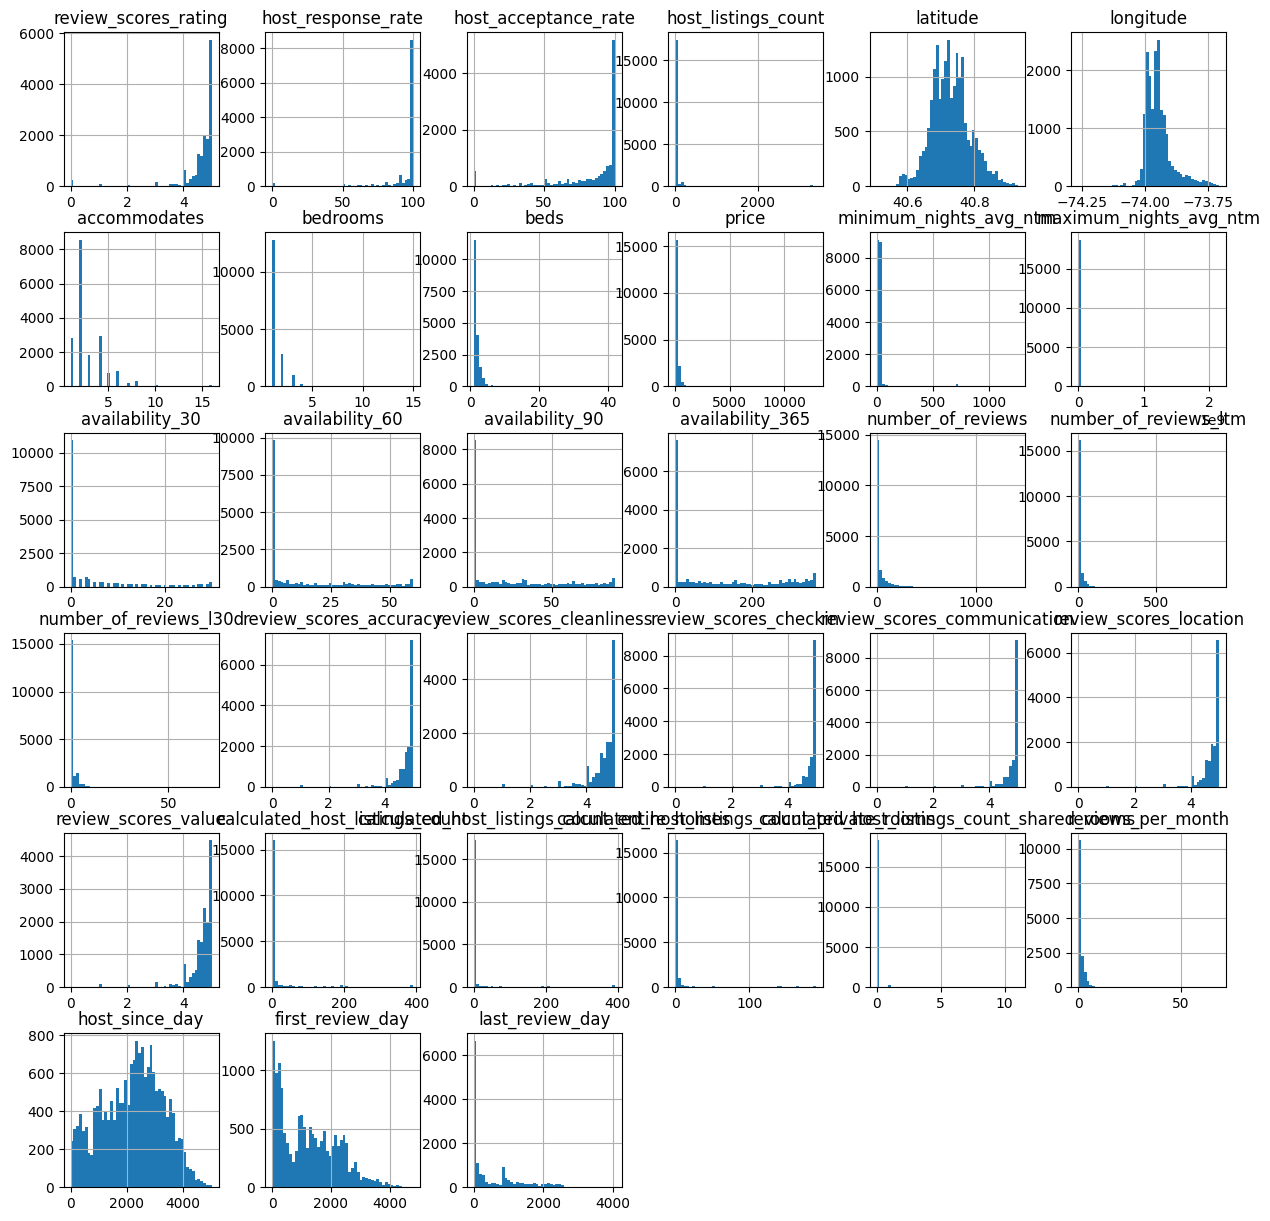

In [155]:
train_df[num_var].hist(bins=50, figsize=(15, 15));

Bar plots for categorical variables:

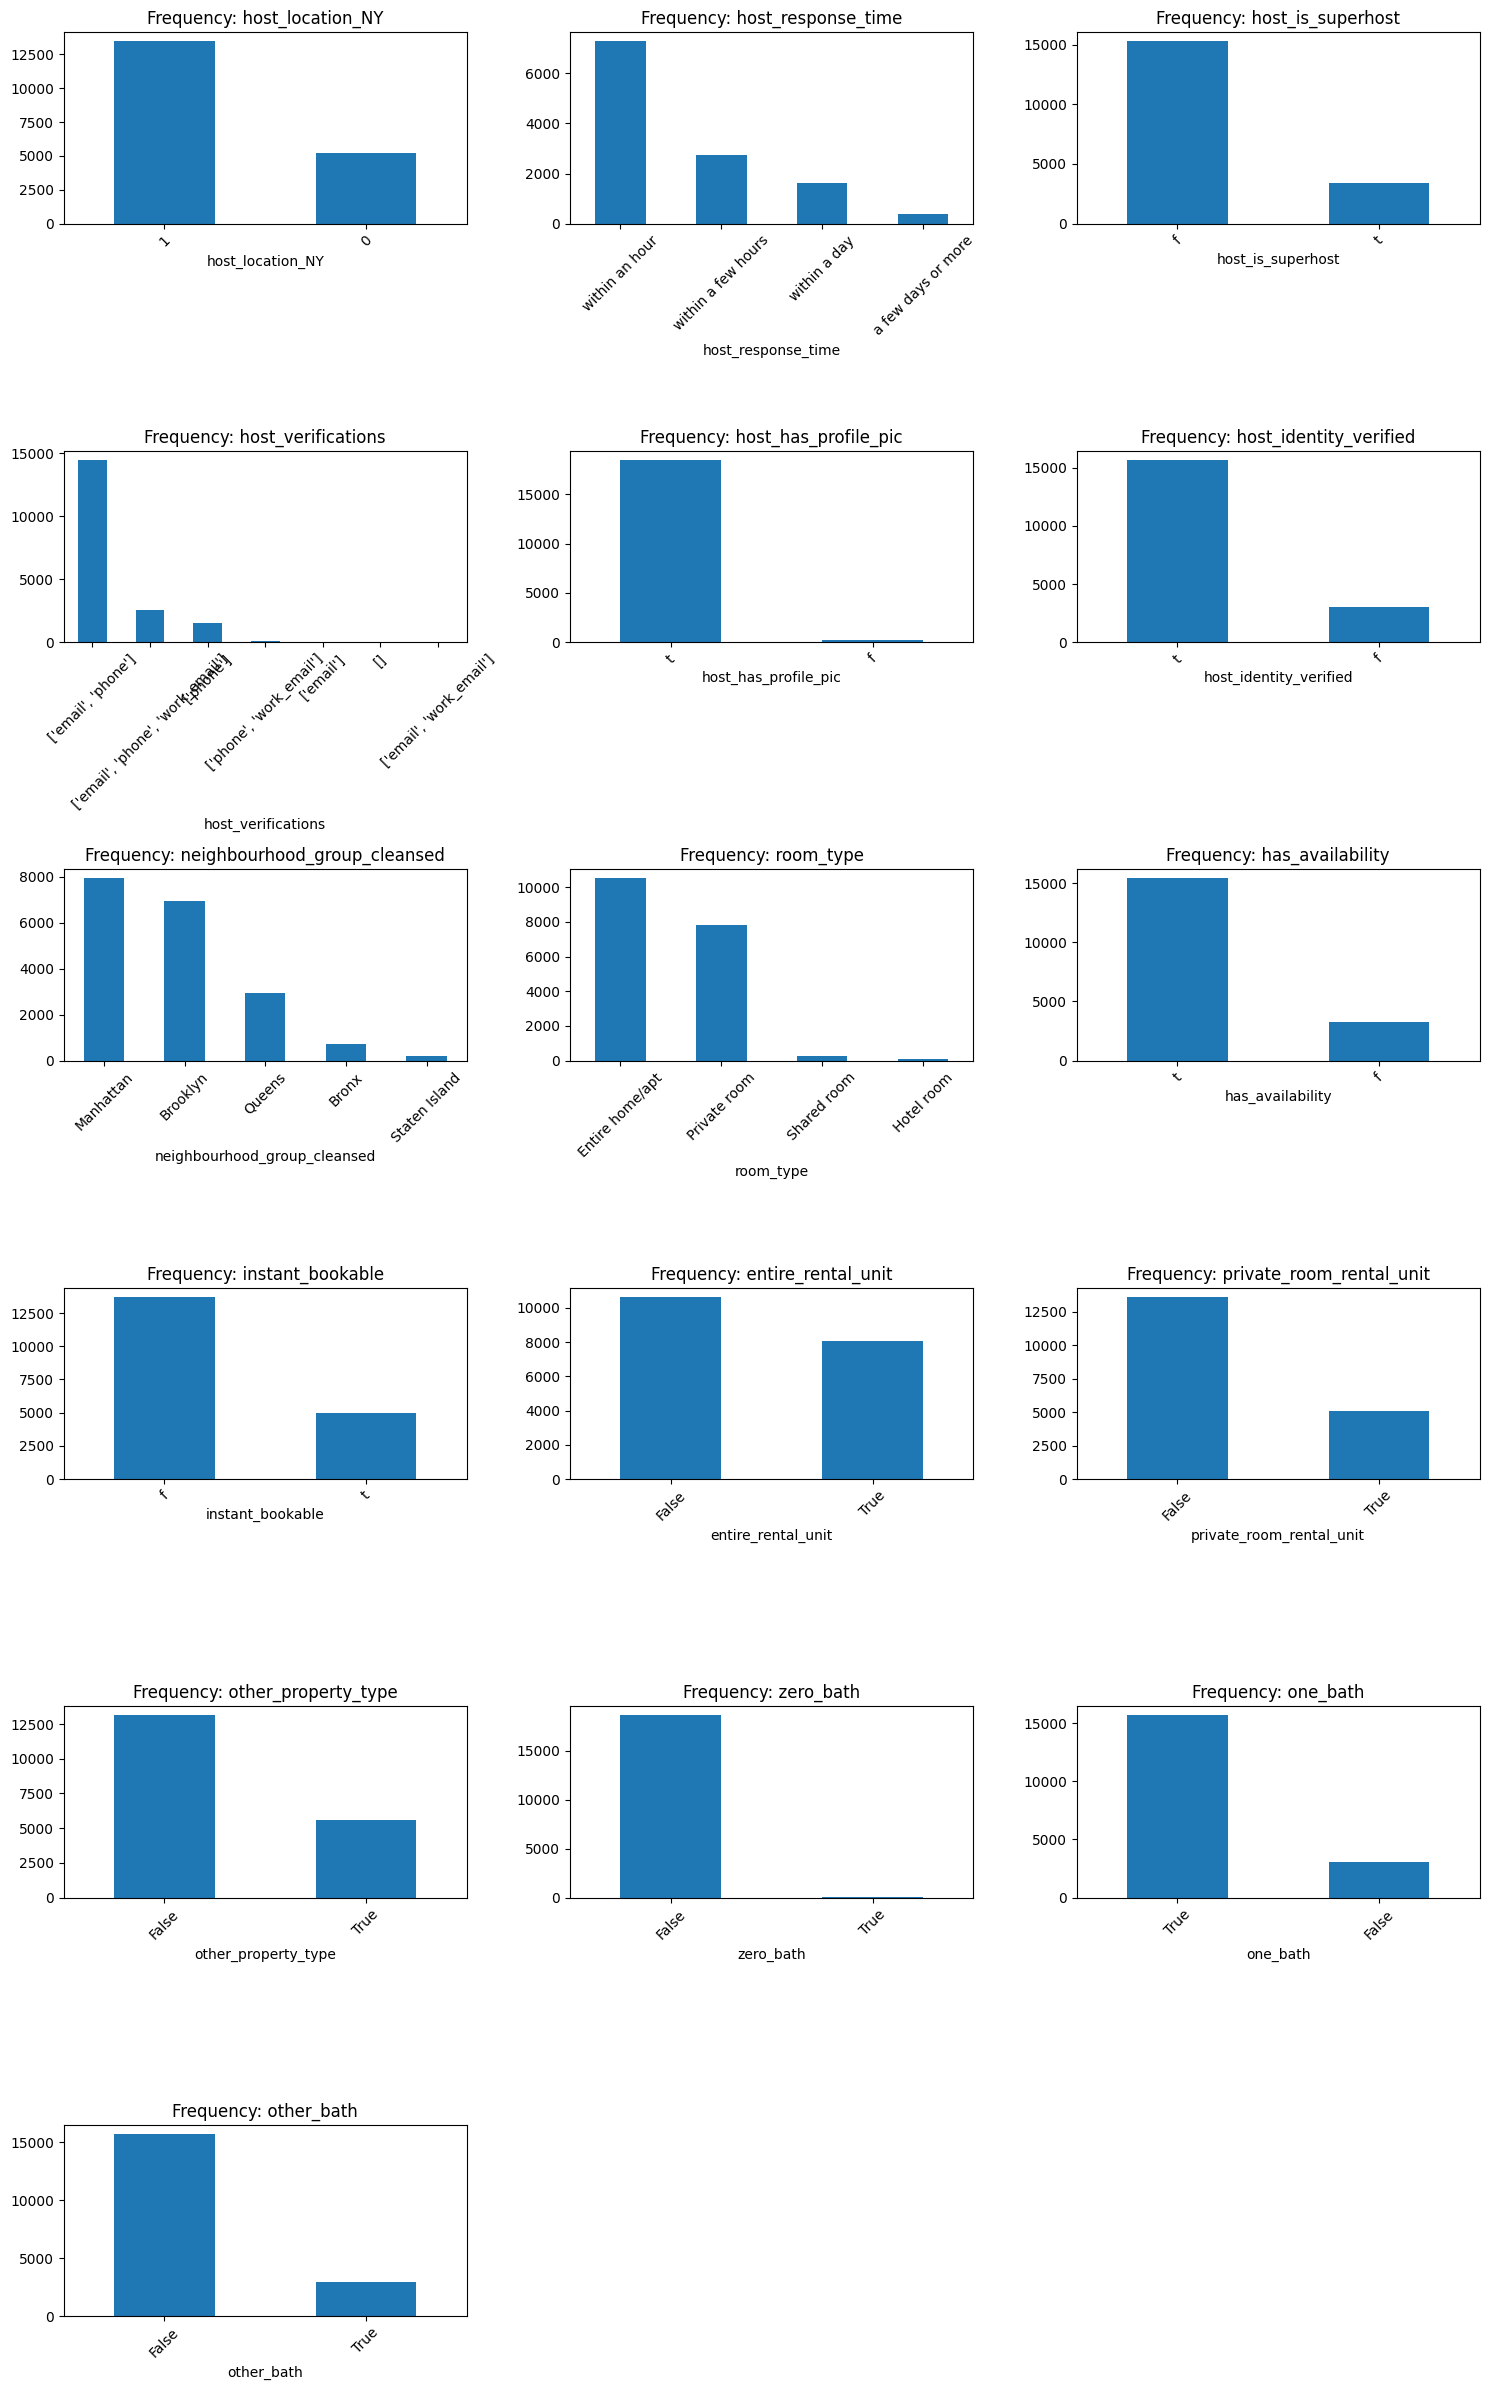

In [156]:
n = len(cat_var)
n_cols = 3  # Number of columns
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(cat_var):
    train_df[var].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Frequency: {var}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.4 Bivariate plots

Correlation between variables:

In [157]:
train_df[num_var].corr(method="pearson")

,review_scores_rating,host_response_rate,host_acceptance_rate,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_day,first_review_day,last_review_day
review_scores_rating,1.000000,0.106215,0.039546,-0.013754,-0.045547,0.009887,0.028731,0.021707,0.024613,0.028364,-0.048270,-0.000865,0.009642,0.029000,0.043658,0.058722,0.101573,0.082082,0.091650,0.827404,0.772233,0.698175,0.745192,0.592273,0.831304,-0.033273,0.006424,-0.069794,-0.035927,0.101169,0.058019,-0.015163,-0.184065
host_response_rate,0.106215,1.000000,0.474046,0.064751,-0.023790,0.054282,0.043701,0.020372,0.050376,-0.033441,0.019388,-0.001795,-0.042634,-0.013413,-0.018891,-0.028482,0.089394,0.126473,0.159010,0.063955,0.085977,0.067511,0.093938,0.029170,0.078158,0.038448,0.015570,0.051606,0.016083,0.148215,-0.044455,-0.102416,-0.306969
host_acceptance_rate,0.039546,0.474046,1.000000,0.050858,-0.007050,0.082741,0.065990,0.010220,0.042212,0.008965,0.005126,0.022639,0.071933,0.103449,0.105258,0.080578,0.139772,0.224882,0.245482,0.004361,0.047953,0.014793,0.014463,-0.008220,0.019249,0.084728,0.064881,0.053750,0.030150,0.267986,-0.178542,-0.207127,-0.409107
host_listings_count,-0.013754,0.064751,0.050858,1.000000,0.037225,-0.091210,-0.001393,0.004090,-0.013282,0.124435,0.806762,-0.005085,0.074354,0.084626,0.093459,0.140747,-0.068704,-0.050202,-0.054960,-0.036850,-0.018649,-0.005877,-0.053163,0.014550,-0.084554,0.753655,0.763832,0.150956,-0.014663,-0.026284,-0.027336,-0.073996,-0.040001
latitude,-0.045547,-0.023790,-0.007050,0.037225,1.000000,0.049417,-0.056917,-0.075584,-0.066941,0.026464,0.044483,0.013467,-0.013647,-0.019470,-0.015457,-0.002184,-0.031409,-0.034675,-0.031882,-0.052364,-0.052302,-0.053363,-0.058791,-0.002494,-0.064262,0.070396,0.052814,0.047340,0.030122,-0.034813,-0.028992,0.008626,0.031679
longitude,0.009887,0.054282,0.082741,-0.091210,0.049417,1.000000,-0.002021,0.009102,0.014823,-0.125135,-0.099629,-0.014716,0.151310,0.169561,0.162542,0.098145,0.051176,0.055610,0.079410,-0.007304,0.010579,-0.003300,-0.012641,-0.136117,0.000333,-0.062846,-0.121967,0.099127,0.026290,0.095461,-0.157629,-0.117451,-0.137013
accommodates,0.028731,0.043701,0.065990,-0.001393,-0.056917,-0.002021,1.000000,0.744916,0.760423,0.322877,-0.048657,-0.007441,0.116999,0.103867,0.111698,0.139361,0.052814,0.076388,0.073252,-0.002875,0.038486,0.008669,0.004573,-0.014822,-0.006094,-0.056768,-0.008162,-0.102700,-0.058126,0.090499,-0.045306,-0.057986,-0.114178
bedrooms,0.021707,0.020372,0.010220,0.004090,-0.075584,0.009102,0.744916,1.000000,0.778666,0.274073,-0.014345,-0.017639,0.042640,0.037593,0.055227,0.104551,0.002746,0.033177,0.033625,-0.001239,0.033951,0.014164,0.010816,-0.012274,-0.001073,-0.038027,0.008527,-0.086652,-0.047697,0.035966,-0.020413,-0.057493,-0.106290
beds,0.024613,0.050376,0.042212,-0.013282,-0.066941,0.014823,0.760423,0.778666,1.000000,0.256145,-0.050763,-0.008558,0.085791,0.076586,0.087382,0.121168,0.056445,0.062726,0.064329,-0.000088,0.033672,0.015892,0.010384,-0.015594,0.001552,-0.072368,-0.036324,-0.084138,0.007025,0.067844,-0.033524,-0.037453,-0.117167
price,0.028364,-0.033441,0.008965,0.124435,0.026464,-0.125135,0.322877,0.274073,0.256145,1.000000,0.078624,0.025377,0.175002,0.157392,0.152768,0.116152,-0.033698,-0.003245,-0.011021,0.008254,0.044225,-0.000844,0.006718,0.065921,-0.006676,0.068559,0.095874,-0.037210,-0.027061,0.016521,-0.018945,-0.051539,-0.048649


<ipython-input-158-0f4783709a0e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet", 30)


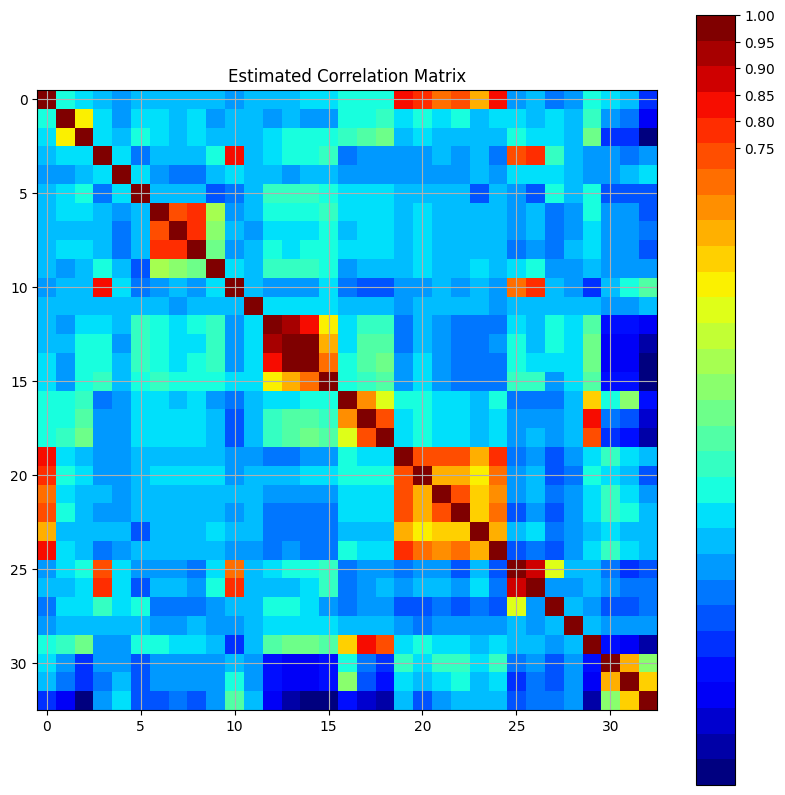

                                    Name feature
0                           review_scores_rating
1                             host_response_rate
2                           host_acceptance_rate
3                            host_listings_count
4                                       latitude
5                                      longitude
6                                   accommodates
7                                       bedrooms
8                                           beds
9                                          price
10                        minimum_nights_avg_ntm
11                        maximum_nights_avg_ntm
12                               availability_30
13                               availability_60
14                               availability_90
15                              availability_365
16                             number_of_reviews
17                         number_of_reviews_ltm
18                        number_of_reviews_l30d
19                  

In [158]:
def VizCorrelationMatrix(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap("jet", 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title("Estimated Correlation Matrix")
    fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
    plt.show()
VizCorrelationMatrix(train_df[num_var])
print(pd.DataFrame(num_var, columns=["Name feature"]))

Plots of the relation between price and numerical variable X:

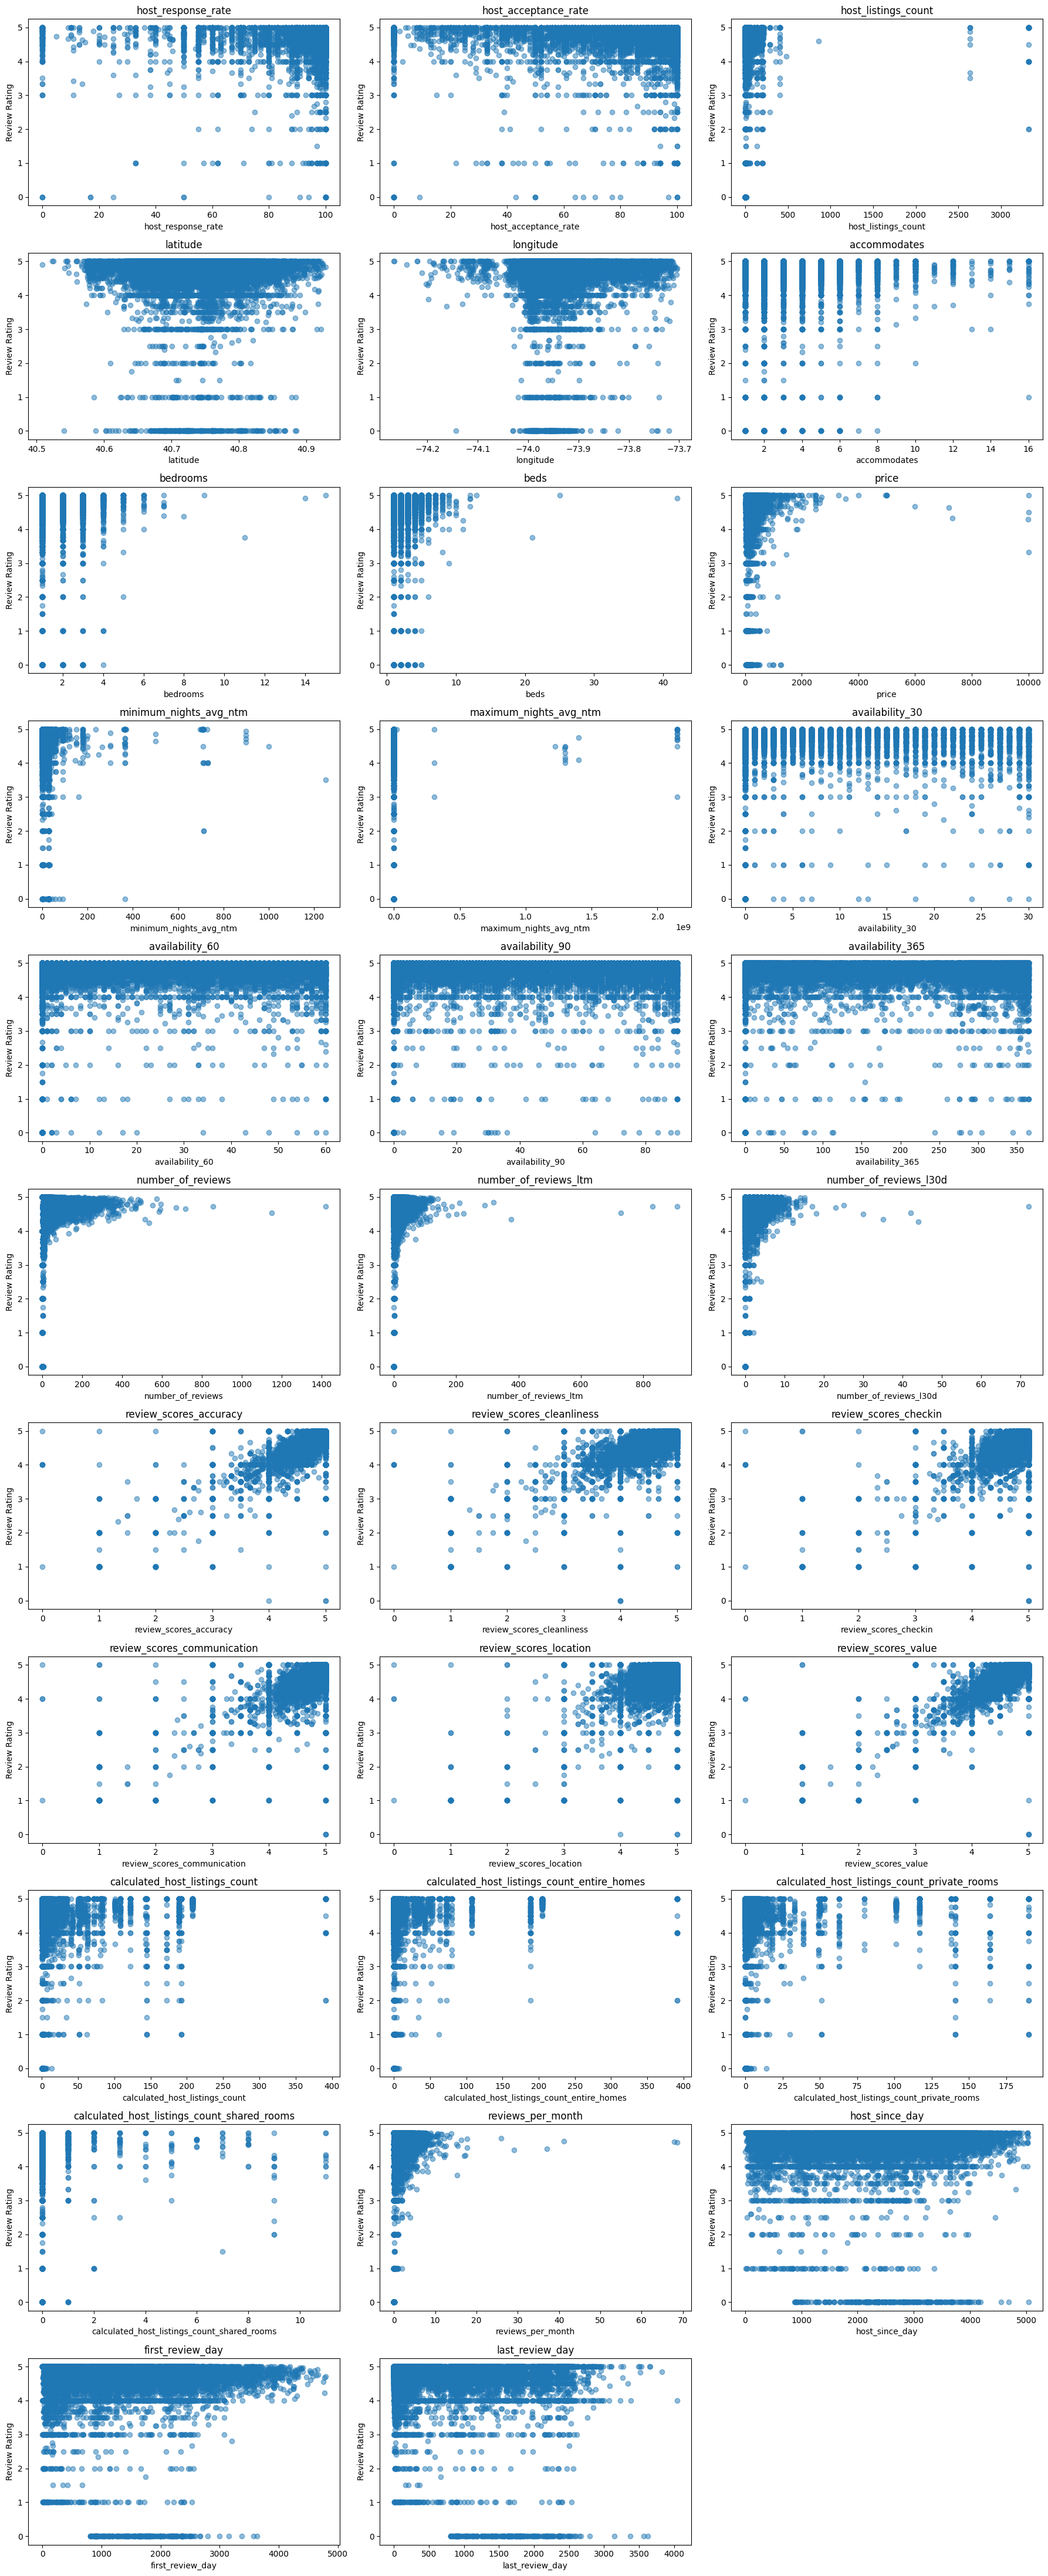

In [160]:
plot_var = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_since_day', 'first_review_day', 'last_review_day']

Z = train_df.copy()
n = len(plot_var)
n_cols = 3  # Number of columns
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, name in enumerate(plot_var):
    ax = axes[i]
    ax.scatter(Z[name], Z["review_scores_rating"], alpha=0.5)
    ax.set_xlabel(name)
    ax.set_ylabel("Review Rating")
    ax.set_title(f"{name}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Box plot between the price and the categorical variables:

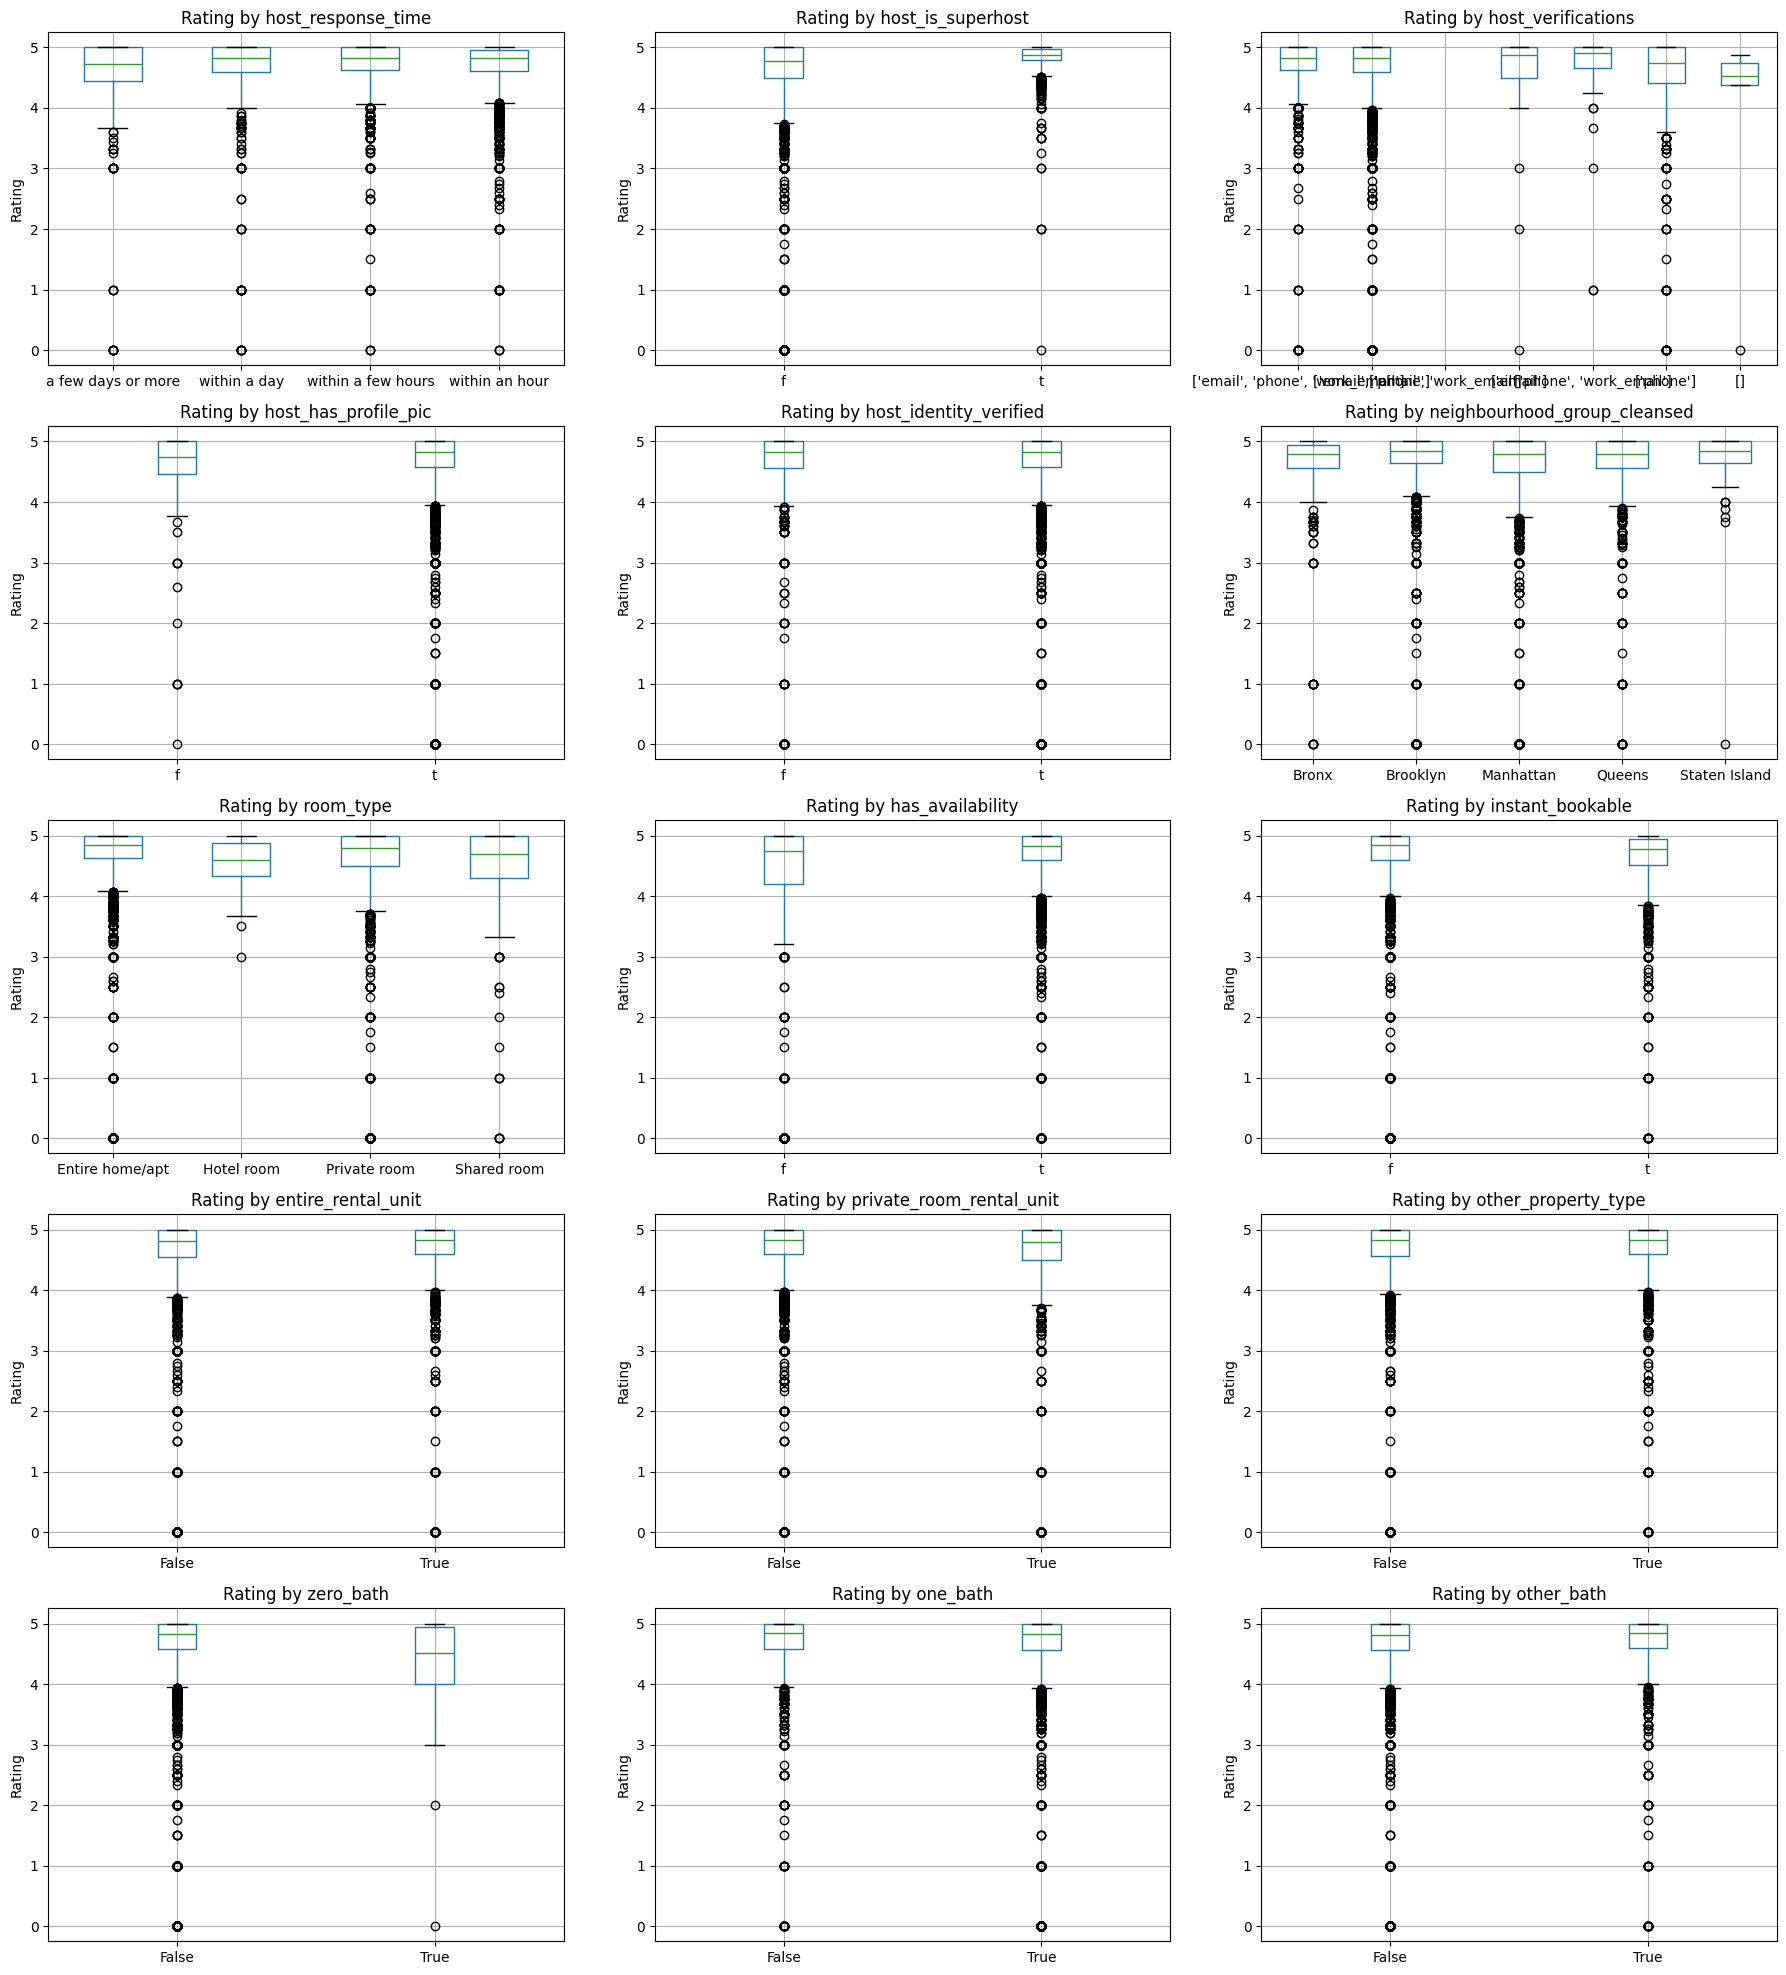

In [161]:
boxplot_var = ['host_response_time', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type', 'has_availability', 'instant_bookable', 'entire_rental_unit', 'private_room_rental_unit', 'other_property_type', 'zero_bath', 'one_bath', 'other_bath']
n = len(boxplot_var)
n_cols = 3  # Number of columns
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(boxplot_var):
    train_df.boxplot(column="review_scores_rating", by=var, ax=axes[i])
    axes[i].set_title(f"Rating by {var}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Rating")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("")
plt.tight_layout()
plt.show()

Empirical P(Y|X=x) for categorical  variables:

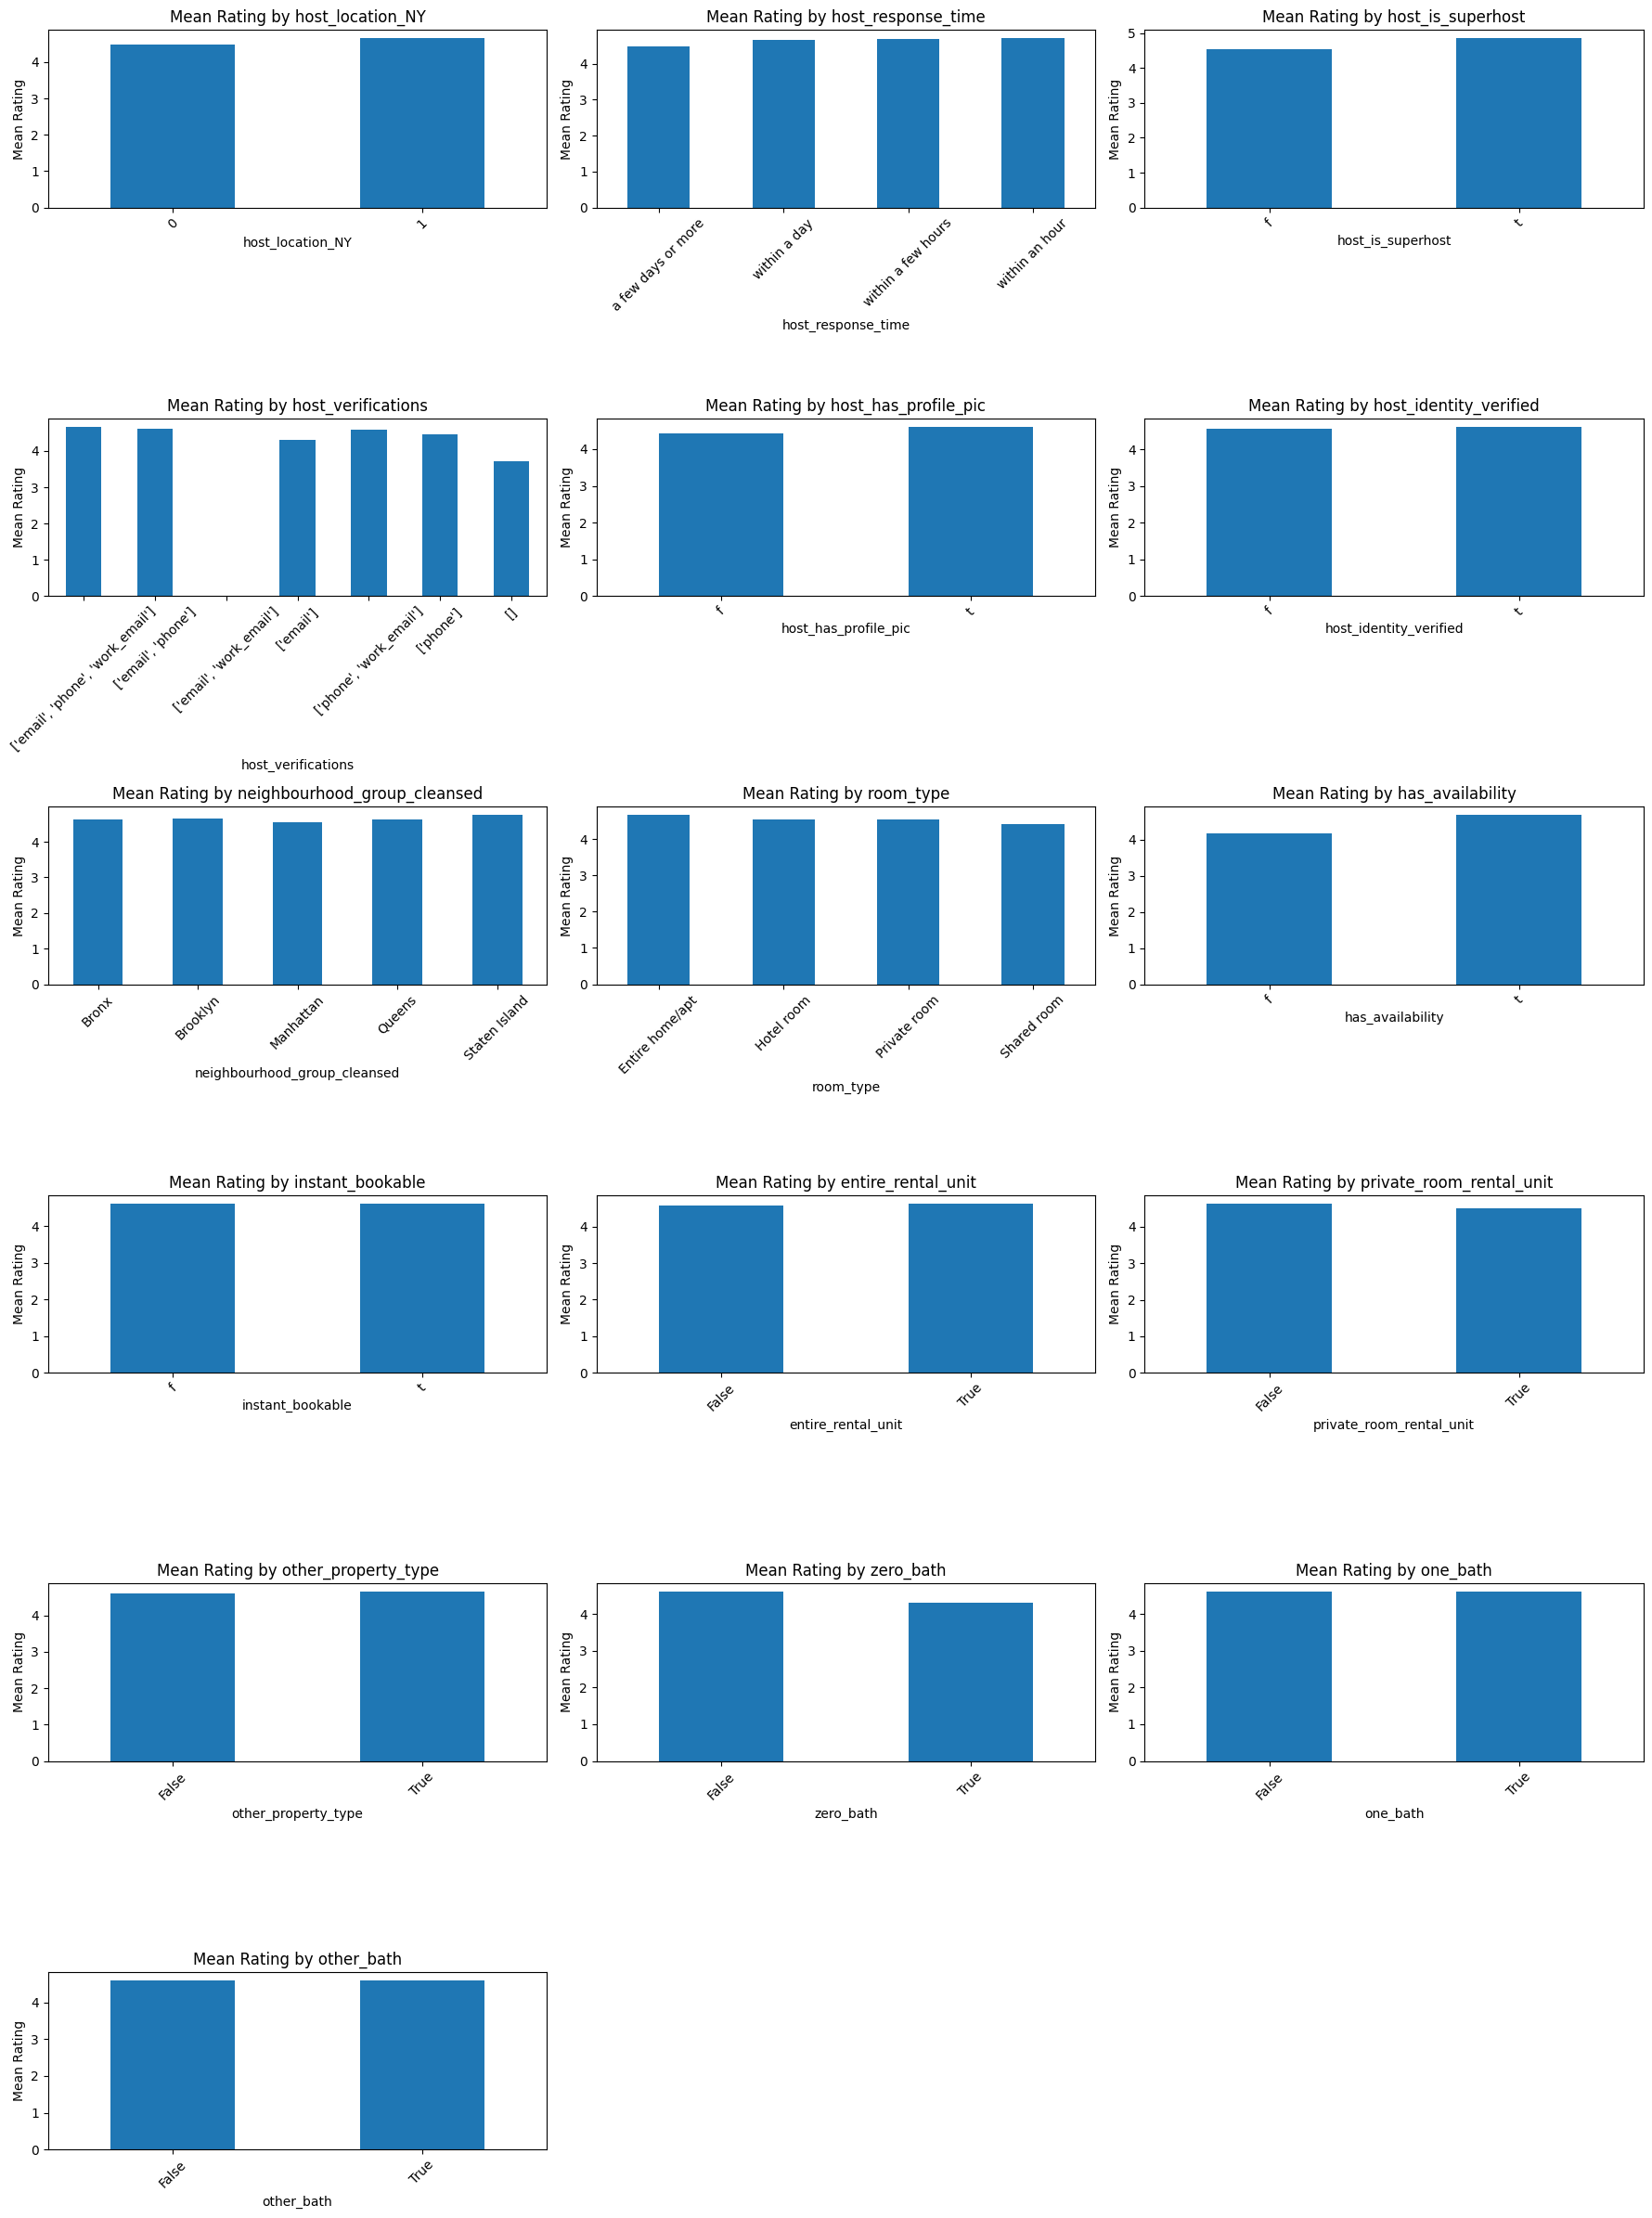

In [162]:
n = len(cat_var)
n_cols = 3  # Number of columns
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(cat_var):
    ax = axes[i]
    train_df.groupby(var)['review_scores_rating'].mean().plot(kind="bar", ax=ax)
    ax.set_title(f"Mean Rating by {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Mean Rating")
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2. Feature engineering

Build datasets with dummies for categorical variables:

In [163]:
def add_dummies(df, cat_var):
    """Return new dataframe with dummy variables for specified categorical variables."""
    dummies_df = pd.DataFrame()
    for var in cat_var:
        aux = pd.get_dummies(df[[var]], prefix=f"ind_{var}", drop_first=False)
        dummies_df = pd.concat([dummies_df, aux], axis=1)
    return dummies_df

def build_X_y(df, num_var, cat_var, name_target, extra_cols=None):
    """Build datasets X, y for modelling, including extra dummy variables if needed."""
    num_df = df[num_var]
    dum_df = add_dummies(df, cat_var)

    if extra_cols:
        extra_df = df[extra_cols]
        X = pd.concat([num_df, dum_df, extra_df], axis=1)
    else:
        X = pd.concat([num_df, dum_df], axis=1)

    y = df[name_target]
    return X, y

name_target = "review_scores_rating"
X_train, y_train = build_X_y(train_df, num_var, cat_var, name_target)
X_validation, y_validation = build_X_y(validation_df, num_var, cat_var, name_target)
X_test, y_test = build_X_y(test_df, num_var, cat_var, name_target)

common_cols = list(set(X_train.columns) & set(X_validation.columns) & set(X_test.columns))
X_train = X_train[common_cols]
X_validation = X_validation[common_cols]
X_test = X_test[common_cols]

To model the review ratings of Airbnb listings, initially a linear regression is applied as a starting approach to gain some first insights. Linear regression is a simple, interpretable model that allows for quick insight into the relationships between predictors (such as price, location, number of reviews) and the outcome variable (review rating). It also provides direct estimates of feature coefficients, which are useful for understanding variable importance and directionality. However, review ratings are likely influenced by complex, non-linear interactions between multiple features — something linear models cannot capture well. To address this, we proceeded with XGBoost’s regression variant, XGBRegressor, a gradient boosting algorithm that is well-suited for continuous outcomes. XGBRegressor is capable of modeling non-linear relationships, handling missing values, and improving performance through boosting.

### 2.1 Linear Regression model

Available features:

In [165]:
print(X_train.columns)

Index(['availability_30', 'first_review_day', 'bedrooms',
       'number_of_reviews_l30d', 'number_of_reviews_ltm', 'accommodates',
       'ind_neighbourhood_group_cleansed_Queens', 'host_location_NY',
       'ind_host_verifications_['email', 'phone', 'work_email']',
       'private_room_rental_unit', 'availability_90', 'number_of_reviews',
       'review_scores_checkin', 'ind_host_verifications_['email']', 'one_bath',
       'ind_host_response_time_within a few hours', 'entire_rental_unit',
       'host_response_rate', 'calculated_host_listings_count_private_rooms',
       'ind_host_response_time_within an hour', 'availability_60',
       'availability_365', 'beds', 'ind_host_response_time_within a day',
       'latitude', 'ind_host_verifications_[]', 'host_since_day',
       'host_acceptance_rate', 'review_scores_cleanliness',
       'calculated_host_listings_count_entire_homes', 'longitude',
       'review_scores_location', 'host_listings_count',
       'maximum_nights_avg_ntm', 'mi

After the above shown preliminary data analysis and running a few linear regressions, the following variables are selected to analyse further.

In [166]:
selected_features = ['longitude', 'host_response_rate', 'ind_neighbourhood_group_cleansed_Brooklyn',
       'beds', 'ind_room_type_Entire home/apt',
       'price', 'latitude', 'host_acceptance_rate',
       'bedrooms', 'ind_host_response_time_within an hour',
       'ind_host_has_profile_pic_t', 'ind_host_is_superhost_t',
       'host_listings_count', 'ind_has_availability_t', 'host_since_day',
       'host_location_NY',
       'entire_rental_unit', 'private_room_rental_unit', 'other_property_type',
       'zero_bath', 'one_bath', 'other_bath']

First we fit a linear regression using the Scikit-learn package (for machine learning):

In [167]:
y_train_clean = y_train.dropna()
X_train_clean = X_train.loc[y_train_clean.index]

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_clean[selected_features])

linreg = LinearRegression()
linreg.fit(X_train_imputed, y_train_clean)

LinearRegression()

Create dataframe of estimated coefficients:

In [168]:
est_coef = pd.DataFrame(linreg.coef_, index=selected_features, columns=["estimated coefficient"])
est_coef.loc["intercept"] = linreg.intercept_
display(est_coef)

,estimated coefficient
longitude,0.091587
host_response_rate,0.002615
ind_neighbourhood_group_cleansed_Brooklyn,0.018864
beds,-0.005176
ind_room_type_Entire home/apt,0.114456
price,0.000057
latitude,-0.277733
host_acceptance_rate,-0.001062
bedrooms,-0.025643
ind_host_response_time_within an hour,0.021385


The predicted review ratings following from the linear regression:

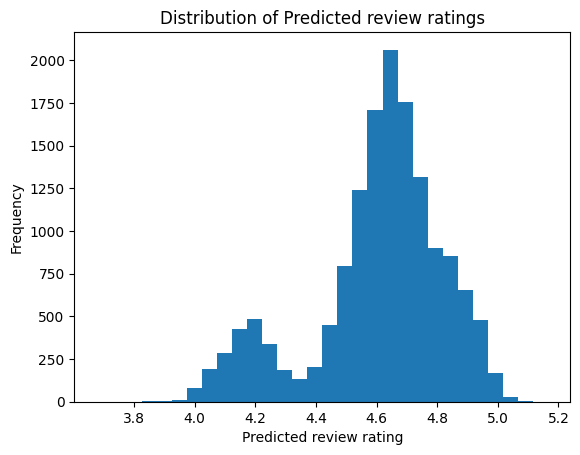

In [170]:
y_pred_train = linreg.predict(X_train_imputed)
plt.hist(y_pred_train, bins=30)
plt.xlabel("Predicted review rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted review ratings")
plt.show()

The root mean square error and the R squared give some insight into the performance of the model. The higher the R squared the better the variance of the review ratings is explained by the independent variables in the model. And the lower the root mean square error the closer the predicted values are to the true values. However the model should not be overfitted to the data.

In [171]:
mse = mean_squared_error(y_train_clean, y_pred_train)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_clean, y_pred_train)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.3f}")

RMSE: 0.74
R² score: 0.080


Here we compare the predicted outcomes of the model to the actual values:

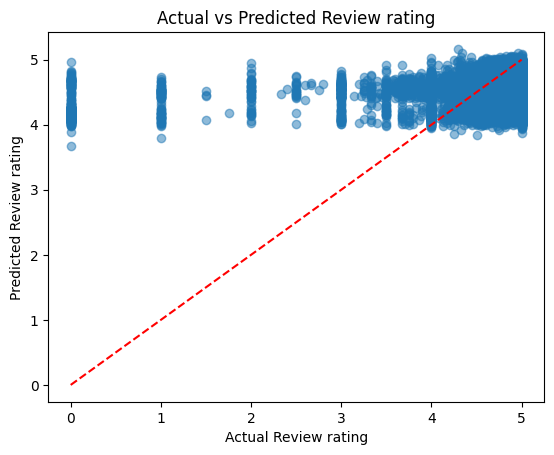

In [173]:
plt.scatter(y_train_clean, y_pred_train, alpha=0.5)
plt.plot([y_train_clean.min(), y_train_clean.max()], [y_train_clean.min(), y_train_clean.max()], 'r--')
plt.xlabel("Actual Review rating")
plt.ylabel("Predicted Review rating")
plt.title("Actual vs Predicted Review rating")
plt.show()

Evaluating the performance of the linear regression model on the validation dataset:

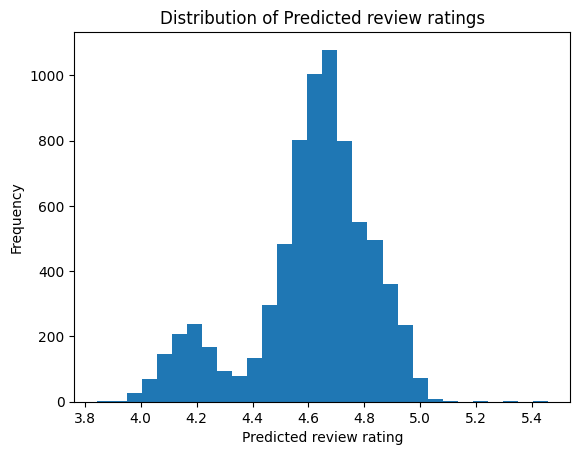

In [174]:
y_validation_clean = y_validation.dropna()
X_validation_clean = X_validation.loc[y_validation_clean.index]

imputer = SimpleImputer(strategy='mean')
X_validation_imputed = imputer.fit_transform(X_validation_clean[selected_features])

y_pred_validation = linreg.predict(X_validation_imputed)
plt.hist(y_pred_validation, bins=30)
plt.xlabel("Predicted review rating")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted review ratings")
plt.show()

In [175]:
mse = mean_squared_error(y_validation_clean, y_pred_validation)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation_clean, y_pred_validation)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.3f}")

RMSE: 0.73
R² score: 0.079


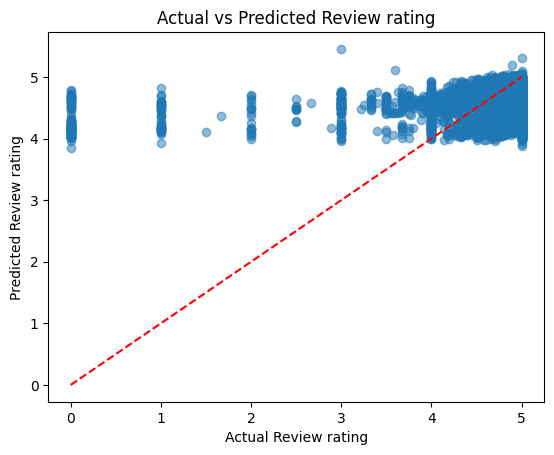

In [176]:
plt.scatter(y_validation_clean, y_pred_validation, alpha=0.5)
plt.plot([y_validation_clean.min(), y_validation_clean.max()], [y_validation_clean.min(), y_validation_clean.max()], 'r--')
plt.xlabel("Actual Review rating")
plt.ylabel("Predicted Review rating")
plt.title("Actual vs Predicted Review rating")
plt.show()

The linear regression model, while useful as a starting point, appears to have limited predictive power in this case. The predicted values differ noticeably from the actual review scores, suggesting that the model may not be capturing the underlying complexity of the data. This could be due to non-linear relationships or interactions between features that linear regression cannot model effectively. To address this, a more flexible algorithm such as XGBoost will be explored.

### Xgboost

In [177]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_imputed, y_train_clean)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

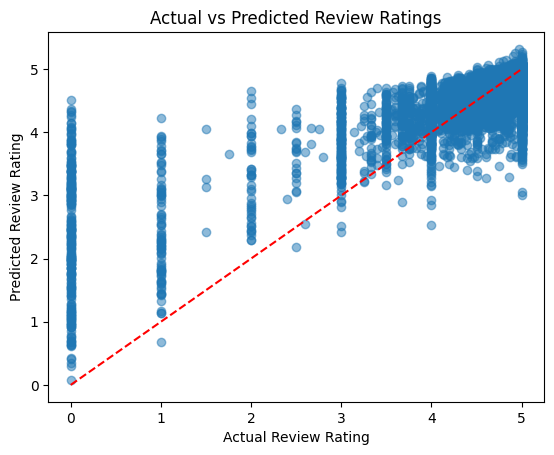

RMSE: 0.474
R²: 0.625


In [178]:
hat_target_train_xgb = xgb_model.predict(X_train_imputed)

# Scatter plot of actual vs predicted
plt.scatter(y_train_clean, hat_target_train_xgb, alpha=0.5)
plt.plot([y_train_clean.min(), y_train_clean.max()],
         [y_train_clean.min(), y_train_clean.max()],
         'r--')
plt.xlabel("Actual Review Rating")
plt.ylabel("Predicted Review Rating")
plt.title("Actual vs Predicted Review Ratings")
plt.show()

# Optional: Print metrics
mse = mean_squared_error(y_train_clean, hat_target_train_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_train_clean, hat_target_train_xgb)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

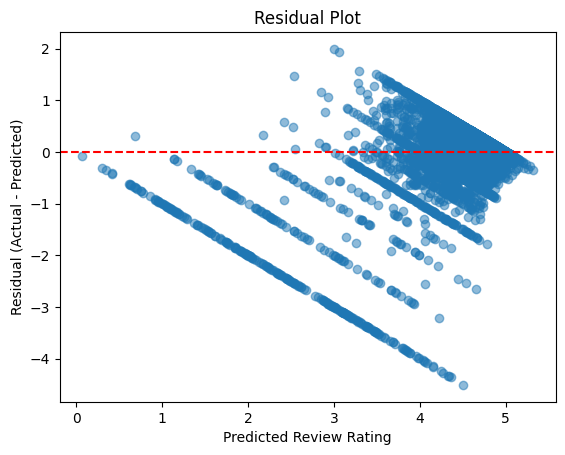

In [179]:
residuals = y_train_clean - hat_target_train_xgb

plt.scatter(hat_target_train_xgb, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Review Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

From the graphs we see that with xgboost we already get much better predictions compared to the simple linear regression. With an increase of the R-squared value from 0.079 to 0.625 and a decrease of the RMSE from 0.730 to 0.474. Next the perfomance is evaluated using the validation dataset:

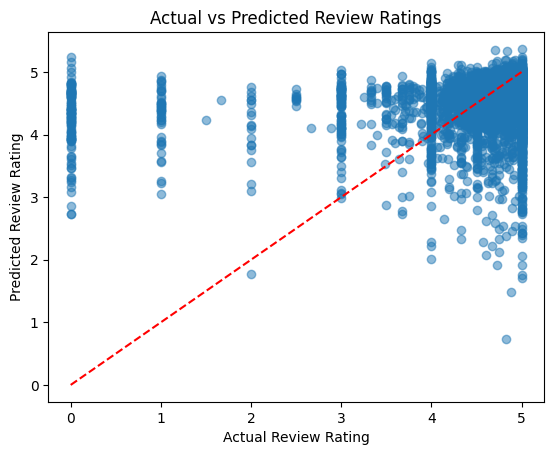

RMSE: 0.772
R²: -0.029


In [180]:
hat_target_validation_xgb = xgb_model.predict(X_validation_imputed)

# Scatter plot of actual vs predicted
plt.scatter(y_validation_clean, hat_target_validation_xgb, alpha=0.5)
plt.plot([y_validation_clean.min(), y_validation_clean.max()],
         [y_validation_clean.min(), y_validation_clean.max()],
         'r--')
plt.xlabel("Actual Review Rating")
plt.ylabel("Predicted Review Rating")
plt.title("Actual vs Predicted Review Ratings")
plt.show()

# Optional: Print metrics
mse = mean_squared_error(y_validation_clean, hat_target_validation_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_validation_clean, hat_target_validation_xgb)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

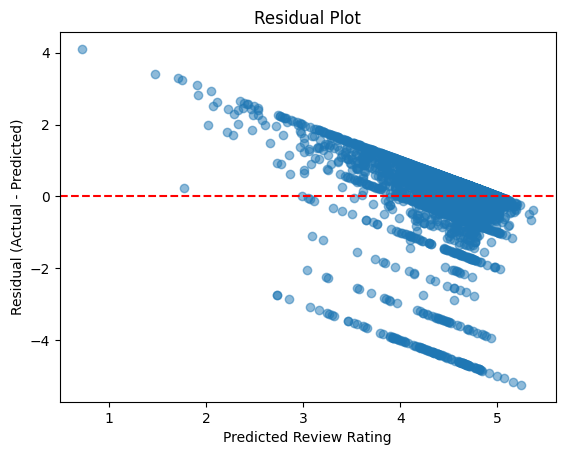

In [181]:
residuals = y_validation_clean - hat_target_validation_xgb

plt.scatter(hat_target_validation_xgb, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Review Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

# 3. Conclusion

In this analysis, we explored with predicting review ratings for Airbnb listings in New York. The process began with an initial exploratory analysis to understand the structure of the data, distributions of key variables, and potential relationships between features and the outcome variable. We then applied a linear regression model as a baseline. While this approach provided some interpretability, it struggled to capture the complexity of the relationships in the data, likely due to non-linear interactions and feature dependencies.

To address these limitations, we employed XGBoost, a more advanced machine learning model capable of modeling non-linear relationships. On the training data, XGBoost achieved a promising R-squared score of 0.625, indicating that the model explained a substantial portion of the variance. However, when evaluated on the validation set, the performance dropped significantly, with an R-squared of -0.029. This suggests overfitting, where the model learned patterns too specific to the training data and failed to generalize.

A likely explanation for this discrepancy is the skewed distribution of review ratings, which are heavily concentrated around the highest values (i.e., close to 5.0). This imbalance may lead the model to default to predicting high ratings, reducing its ability to capture meaningful variation.

For future work, it would be beneficial to address this class imbalance by either re-sampling the data to better represent lower ratings or using techniques that emphasize rare outcomes during training. Additionally, exploring alternative model evaluation metrics or reframing the problem (e.g., classifying reviews into sentiment bands) could potentionally provide more insights.